In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

In [2]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [            
            [ 178.478431, -17.6426563 ], 
            [ 178.4875358, -17.6427653 ], 
            [ 178.5163223, -17.6076001 ], 
            [ 178.5020381, -17.6065642 ], 
            [ 178.478431, -17.6426563 ],
        ]
    ],
}

In [3]:
time_of_interest = "2017-06-01/2021-08-01"

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 7}}, #cloud cover threshold, higher = more images
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 12 Items


In [5]:
items.reverse()
for i in items:
    print(f"Choosing {i.id} from {i.datetime.date()}")

Choosing S2A_MSIL2A_20170802T222021_R029_T60KXF_20210210T182339 from 2017-08-02
Choosing S2A_MSIL2A_20180618T221941_R029_T60KXF_20201011T233604 from 2018-06-18
Choosing S2B_MSIL2A_20180812T221939_R029_T60KXF_20201011T005925 from 2018-08-12
Choosing S2B_MSIL2A_20180822T221929_R029_T60KXF_20201011T054025 from 2018-08-22
Choosing S2A_MSIL2A_20190527T223011_R072_T60KXF_20201006T190111 from 2019-05-27
Choosing S2B_MSIL2A_20190608T221949_R029_T60KXF_20201005T235143 from 2019-06-08
Choosing S2B_MSIL2A_20200423T221939_R029_T60KXF_20200921T204743 from 2020-04-23
Choosing S2B_MSIL2A_20200705T223009_R072_T60KXF_20201027T081634 from 2020-07-05
Choosing S2A_MSIL2A_20200717T221941_R029_T60KXF_20200816T120046 from 2020-07-17
Choosing S2A_MSIL2A_20210622T221941_R029_T60KXF_20210625T064821 from 2021-06-22
Choosing S2B_MSIL2A_20210707T221939_R029_T60KXF_20210708T142045 from 2021-07-07
Choosing S2A_MSIL2A_20210722T221941_R029_T60KXF_20210723T073251 from 2021-07-22


In [6]:
hrefList = []
for i in items:
    asset_href = i.assets["visual"].href
    signed_href = pc.sign(asset_href)
    hrefList.append(signed_href)
    #print(signed_href)
print(len(hrefList))

12


In [7]:
import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [8]:
imgList = []
for signed_href in hrefList:    
    with rasterio.open(signed_href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        band_data = ds.read(window=aoi_window)
       
        img = Image.fromarray(np.transpose(band_data, axes=[1, 2, 0]))
        w = img.size[0]
        h = img.size[1]
        aspect = w / h
        target_w = 800
        target_h = (int)(target_w / aspect)
        img.resize((target_w, target_h), Image.BILINEAR)        
        imgList.append(img)      
   
    

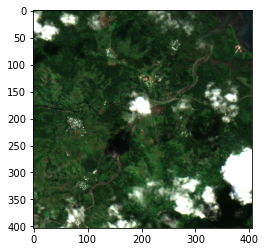

In [9]:
for img in imgList:
    plt.imshow(img)

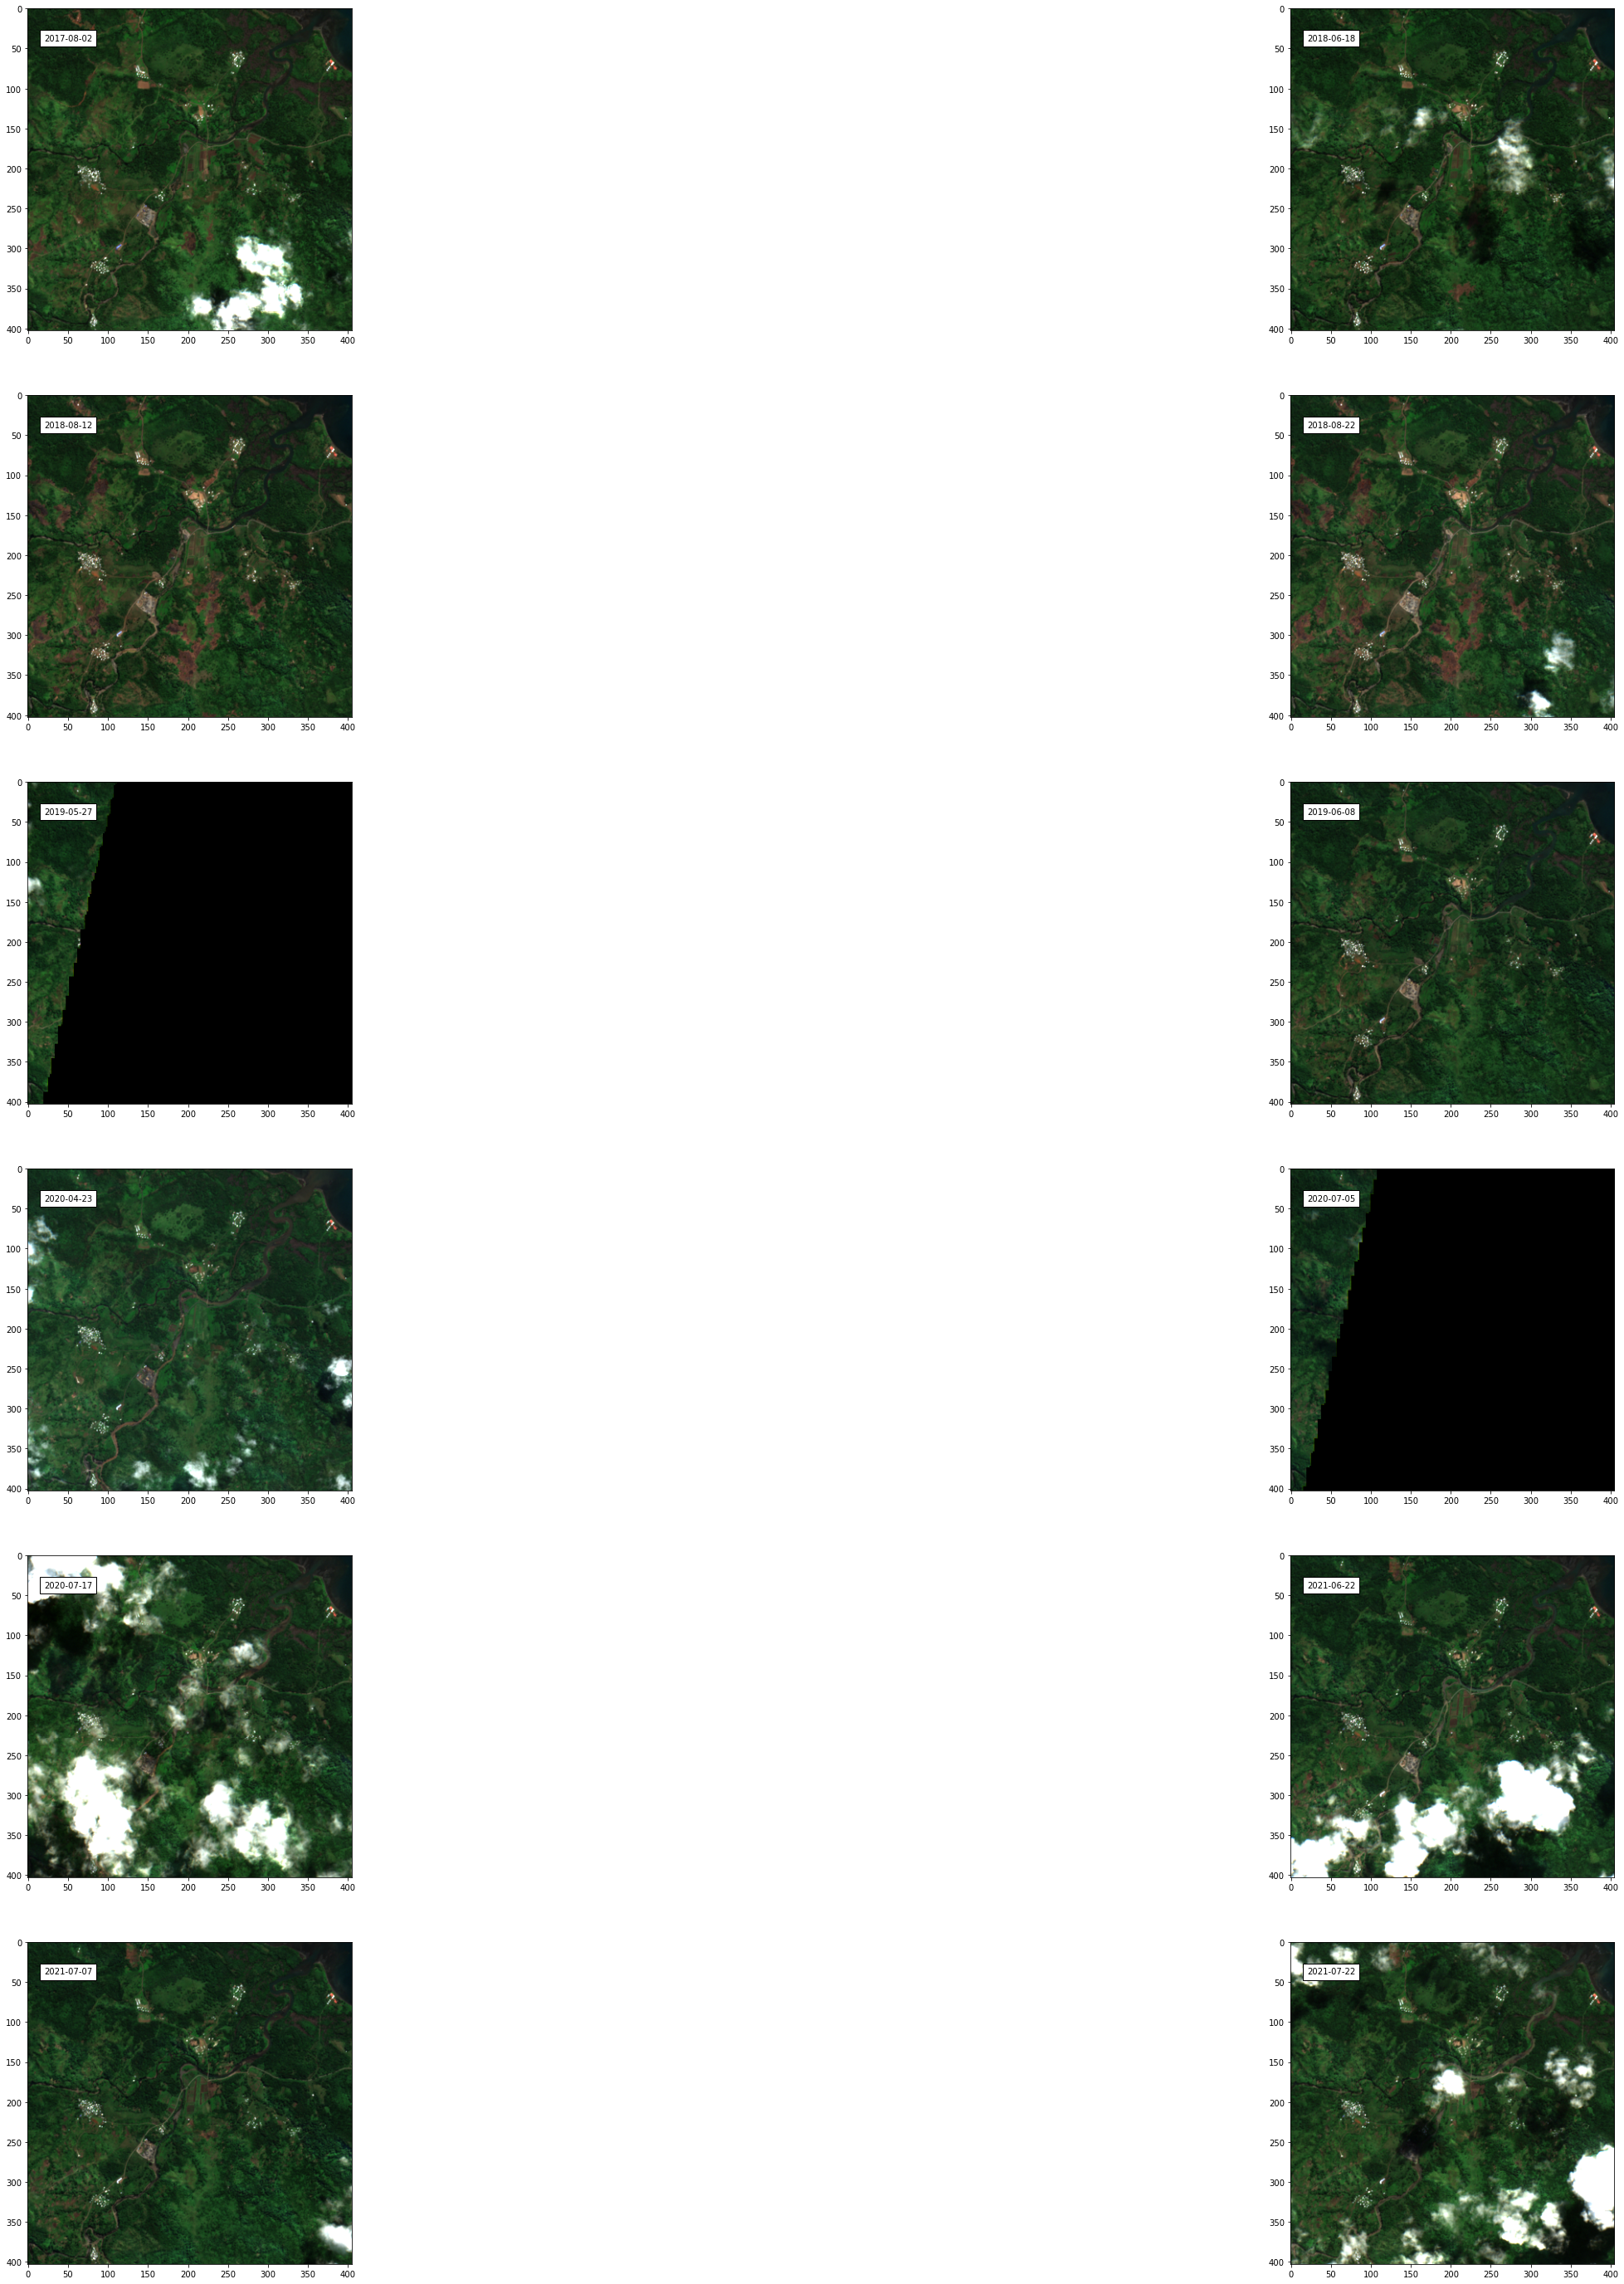

In [10]:
cols = 2
rows = len(imgList) / 2
rows = int(rows)
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(50,50))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(imgList):
            axes[i, j].imshow(imgList[img_count])
            txt = items[img_count].datetime.date()
            axes[i, j].text(20, 40, txt, bbox={'facecolor': 'white', 'pad': 5})
            img_count+=1

12


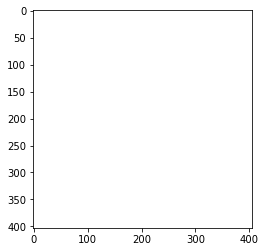

In [17]:
fig = plt.figure()

# initiate an empty  list of "plotted" images 
myimages = []
print(len(imgList))
#loops through available png:s
for img in imgList:
    imgplot = plt.imshow(img)
    # append AxesImage object to the list
    myimages.append([imgplot])

## create an instance of animation
my_anim = animation.ArtistAnimation(fig, myimages, interval=1000, blit=True, repeat_delay=1000)

## NB: The 'save' method here belongs to the object you created above
#my_anim.save("animation.mp4")

## Showtime!
plt.show()
